In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf


In [9]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

In [2]:
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from tensorflow.compat.v1.keras.utils import model_to_dot
from tensorflow.compat.v1.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [7]:
#MNIST dataset parameters.

num_classes = 10 # 0 to 9 digits

num_features = 784 # 28*28

# Training parameters.

learning_rate = 0.01

epochs = 10000

batch_size = 256

display_step = 50

In [12]:
train_data = pd.read_csv(r"files/fashion-mnist_train.csv")
test_data = pd.read_csv(r"files/fashion-mnist_test.csv")
train_data.shape

(60000, 785)

In [16]:
# Create a dictionary for each type of label 
labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
          "Sandal","Shirt","Sneaker","Bag","Ankle Boot"]

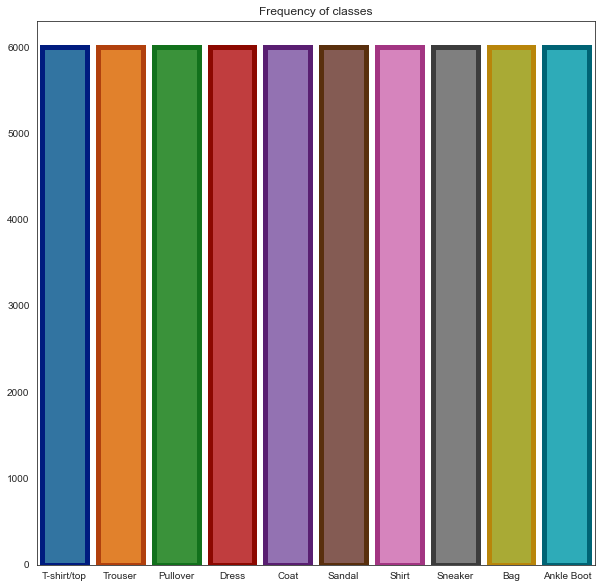

In [17]:
def plot_labels(data):
    plt.figure(figsize=(10,10))
    sns.set_style("white")
    ax = sns.barplot(x=labels, y=pd.value_counts(data['label'].values), linewidth=5,edgecolor=sns.color_palette("dark", 10))
    plt.title("Frequency of classes")

plot_labels(train_data)    

In [ ]:
def plot_images(data): 
    fig = plt.figure(figsize=(12,6))
    X = data.drop('label', axis = 1).values.reshape(data.shape[0], 28, 28)
    for num, x in enumerate(X[0:5]):
        plt.subplot(1,5,num+1)
        plt.axis('off')
        plt.imshow(x)
        plt.title(labels[data.label[num]])
plot_images(train_data)

In [13]:
x_train, x_test = np.array(train_data.iloc[:,1:], np.float32), np.array(test_data.iloc[:,1:], np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test/ 255.
x_train.shape

(60000, 784)

In [35]:
y_train = train_data.iloc[:,:1].to_numpy()
y_test = test_data.iloc[:,:1].to_numpy()
#y_train = tf.keras.utils.to_categorical(y_train, 10)
#y_test = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
weights = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# Bias of shape [10], the total number of classes.
biases = tf.Variable(tf.zeros([num_classes]), name="bias")

## LogisticRegression

In [22]:
"""
def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, weights) + biases)

def cross_entropy(y_true, y_pred):
    y_true = tf.one_hot(y_true, 10)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    cost = tf.reduce_mean(-tf.compat.v1.reduce_sum(y_true*tf.math.log(y_pred), reduction_indices=1))
    
    return cost

def accuracy(y_true, y_pred):
    
    #correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #return accuracy
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.SGD(learning_rate)
def grad(x, y):
    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss_val = cross_entropy(y, y_pred)
    gradients = tape.gradient(loss_val, [weights, biases])
    optimizer.apply_gradients(zip(gradients, [weights, biases]))

"""

In [16]:
log_checkpoint = ModelCheckpoint('log_model.h5', save_best_only=True, save_weights_only=True, mode='max', monitor='val_acc')
model_log = Sequential()
model_log.add(Dense(10, input_shape=(784,), activation='softmax'))
model_log.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])        
history = model_log.fit(x_train, y_train, batch_size=500, validation_data=(x_test, y_test),
                       callbacks=[log_checkpoint], epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 50us/sample - loss: 1.6718 - accuracy: 0.4941 - val_loss: 1.2724 - val_accuracy: 0.6404
Epoch 2/20
60000/60000 [==============================] - 2s 39us/sample - loss: 1.1317 - accuracy: 0.6634 - val_loss: 1.0296 - val_accuracy: 0.6774
Epoch 3/20
60000/60000 [==============================] - 2s 35us/sample - loss: 0.9694 - accuracy: 0.6935 - val_loss: 0.9224 - val_accuracy: 0.7031
Epoch 4/20
60000/60000 [==============================] - 2s 29us/sample - loss: 0.8856 - accuracy: 0.7167 - val_loss: 0.8576 - val_accuracy: 0.7249
Epoch 5/20
60000/60000 [==============================] - 2s 37us/sample - loss: 0.8316 - accuracy: 0.7336 - val_loss: 0.8136 - val_accuracy: 0.7377
Epoch 6/20
60000/60000 [==============================] - 2s 33us/sample - loss: 0.7930 - accuracy: 0.7451 - val_loss: 0.7804 - val_accuracy: 0.7467
Epoch 7/20
60000/60000 [==============================] 

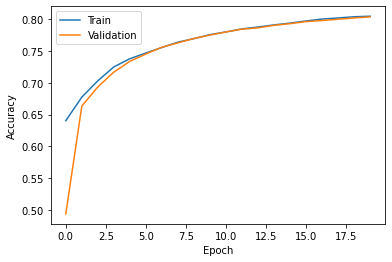

In [24]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Полносвязная нейронная сеть

In [29]:
x_Train, x_Valid, y_Train, y_Valid = train_test_split(x_train, y_train, test_size = 0.3, random_state=42)

In [39]:
nn_checkpoint = ModelCheckpoint('nn_model.h5', save_best_only=True, save_weights_only=True, mode='max', monitor='val_accuracy')
model_nn = Sequential()
model_nn.add(Dense(512, activation='relu', input_shape=(784,)))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(512, activation='relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(10, activation='softmax'))

model_nn.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'],)

history_nn = model_nn.fit(x_Train, y_Train, batch_size=500, validation_data=(x_Valid, y_Valid),
                       callbacks=[nn_checkpoint], epochs=10)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 15s 348us/sample - loss: 2.3541 - accuracy: 0.1160 - val_loss: 2.2828 - val_accuracy: 0.1649
Epoch 2/10
42000/42000 [==============================] - 20s 469us/sample - loss: 2.2877 - accuracy: 0.1475 - val_loss: 2.2115 - val_accuracy: 0.2094
Epoch 3/10
42000/42000 [==============================] - 26s 614us/sample - loss: 2.2228 - accuracy: 0.1823 - val_loss: 2.1437 - val_accuracy: 0.2864
Epoch 4/10
42000/42000 [==============================] - 30s 714us/sample - loss: 2.1614 - accuracy: 0.2225 - val_loss: 2.0789 - val_accuracy: 0.3648
Epoch 5/10
42000/42000 [==============================] - 22s 527us/sample - loss: 2.1003 - accuracy: 0.2700 - val_loss: 2.0163 - val_accuracy: 0.4316
Epoch 6/10
42000/42000 [==============================] - 23s 559us/sample - loss: 2.0419 - accuracy: 0.3116 - val_loss: 1.9555 - val_accuracy: 0.4856
Epoch 7/10
42000/42000 [====================

In [ ]:
model_nn.load_weights('nn_model.h5')
_, score = model_nn.evaluate(x_test, y_test)

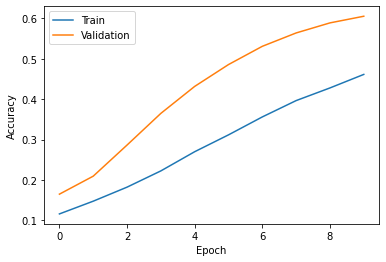

In [46]:

plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# сверточная сеть 

In [50]:
x_TRAIN_reshaped = x_Train.reshape(42000, 28, 28, 1)
x_VALID_reshaped = x_Valid.reshape(18000, 28, 28, 1)
x_TEST_reshaped = x_test.reshape(10000, 28, 28, 1)

In [52]:
cnn_3_checkpoint = ModelCheckpoint('cnn3_model.h5', save_best_only=True, save_weights_only=True, mode='max', monitor='val_accuracy')
model_cnn_3b = tf.keras.models.Sequential()
model_cnn_3b.add(tf.keras.layers.Convolution2D(32, (3,3), input_shape=(28, 28, 1), activation='relu'))
model_cnn_3b.add(tf.keras.layers.BatchNormalization())
model_cnn_3b.add(tf.keras.layers.Convolution2D(32, (3,3), activation='relu'))
model_cnn_3b.add(tf.keras.layers.BatchNormalization())
model_cnn_3b.add(tf.keras.layers.MaxPooling2D((2,2)))
model_cnn_3b.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
model_cnn_3b.add(tf.keras.layers.BatchNormalization())
model_cnn_3b.add(tf.keras.layers.Convolution2D(64, (3,3), activation='relu'))
model_cnn_3b.add(tf.keras.layers.BatchNormalization())
model_cnn_3b.add(tf.keras.layers.MaxPooling2D((2,2)))
model_cnn_3b.add(tf.keras.layers.Flatten())
model_cnn_3b.add(tf.keras.layers.Dense(128, activation='relu'))
model_cnn_3b.add(tf.keras.layers.Dense(32, activation='relu'))
model_cnn_3b.add(tf.keras.layers.Dense(10, activation='softmax'))

model_cnn_3b.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    
history_cnn3 = model_cnn_3b.fit(x_TRAIN_reshaped, y_Train, batch_size=500, validation_data=(x_VALID_reshaped, y_Valid),
                       callbacks=[cnn_3_checkpoint], epochs=10)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 423s 10ms/sample - loss: 0.5688 - accuracy: 0.7963 - val_loss: 2.2853 - val_accuracy: 0.1008
Epoch 2/10
42000/42000 [==============================] - 434s 10ms/sample - loss: 0.3101 - accuracy: 0.8869 - val_loss: 2.3484 - val_accuracy: 0.1551
Epoch 3/10
29500/42000 [====================>.........] - ETA: 1:33 - loss: 0.2449 - accuracy: 0.9106WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


KeyboardInterrupt: 

In [ ]:
plt.plot(history_cnn3.history['acc'])
plt.plot(history_cnn3.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
model_cnn_3b.load_weights('cnn3_model.h5')
_, score = model_cnn_3b.evaluate(x_TEST_reshaped, y_test)
print("Сверточная нейронная сеть-3   accuracy: {0:.3f}".format(score))

С увеличением количества epoch качество увеличивается, Batch Normalization также улучшает качество решения.Слишком долго выполянет на моем компе сверточную сеть, поэтому я не стал ждать завершения) 